In [446]:
# Needed modules :
import os
import gc
import copy
import sklearn

import Drive

import numpy as np
import pandas as pd
import seaborn as sb
import datetime as dt
import matplotlib.pyplot as plt


from sys import getsizeof
from typing import List, Tuple
#from datetime import datetime as dt

import Preprocessing as pre
from functools import reduce

In [426]:
# Function definitions :

def time_indexed_df(df1: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """ Take a return a time-indexed dataframe.
    df1 paramater should contain a column called 'dateTime',
    which contains entries of type pandas._libs.tslibs.timestamps.Timestamp
    """
    _tmp = copy.deepcopy(df1)
    _tmp.index = df1.dateTime
    _tmp.drop('dateTime', axis=1, inplace=True)
    _tmp = _tmp.sort_index()
    gc.collect()
    return _tmp

def fill_nas(df1: pd.core.frame.DataFrame, 
             col_names: List[str] = ['activeInsulin', 'carbs', 'insulin', 'trend'],
             fill_with=0) -> pd.core.frame.DataFrame:
    """  return a new dataframe
    """
    _tmp = copy.deepcopy(df1)
    for name in col_names:
        _tmp[name] = df1[name].fillna(0)
    gc.collect()
    return _tmp

def classify(value: float, limits: Tuple[float, float] = (70, 140)) -> str:
    """ value: Numerical value
        limits: Tuple (lower_boundary, high_boundary)
        
        Returns:
            'hypo'  if value < lower_boundary
            'normo' if lower_boundary <= value <= high_boundary
            'hyper' if value > high_boundary
    """
    if value < limits[0]:
        return 'hypo'
    elif value > limits[1]:
        return 'hyper'
    else:
        return 'normo'
        


In [266]:
d = Drive.Drive()

In [267]:
file_name = 'journal.jl'
file_path = os.path.join('data', file_name)
d.download(file_name   = file_name, 
           target_name = file_path
          )

True

In [268]:
pre.file_filter(file_path)

In [269]:
ls data/

journal_filtered.jl  journal.jl


In [391]:
_raw = pd.read_json(file_path, lines=True)
len(_raw)

221

In [271]:
#_raw[_raw.index.duplicated()]

In [304]:
undesired_columns = [ 
    'LOT',
    'REF', 
    'initSuccess', 
    'secondRound',
    'food'
]

In [305]:
_tmp = (
        _raw.drop(undesired_columns, axis=1)
       ).loc[
                (_raw['type'] == 'data') |
                (_raw['type'] == 'event')
            ]

In [306]:
_t_data = time_indexed_df(_tmp)
_tmp.head()

,BG,IG,activeInsulin,carbs,dateTime,details,insulin,trend,type
0,227.0,226.0,NaN,0.0,2019-02-07 00:27:00,Normal,1.05,0.0,data
1,NaN,190.0,NaN,NaN,2019-02-07 01:26:00,Normal,NaN,NaN,data
2,NaN,174.0,NaN,NaN,2019-02-07 08:49:00,Wake,NaN,0.0,event
5,NaN,148.0,NaN,NaN,2019-02-07 02:24:00,Normal,NaN,NaN,data
6,NaN,131.0,NaN,NaN,2019-02-07 03:14:00,Normal,NaN,NaN,data


In [307]:
_t_data.head()

,BG,IG,activeInsulin,carbs,details,insulin,trend,type
dateTime,,,,,,,,
2019-02-07 00:27:00,227.0,226.0,NaN,0.0,Normal,1.05,0.0,data
2019-02-07 01:26:00,NaN,190.0,NaN,NaN,Normal,NaN,NaN,data
2019-02-07 02:24:00,NaN,148.0,NaN,NaN,Normal,NaN,NaN,data
2019-02-07 03:14:00,NaN,131.0,NaN,NaN,Normal,NaN,NaN,data
2019-02-07 04:24:00,NaN,118.0,NaN,NaN,Normal,NaN,NaN,data


In [308]:
data = fill_nas(_t_data)
data.head()

,BG,IG,activeInsulin,carbs,details,insulin,trend,type
dateTime,,,,,,,,
2019-02-07 00:27:00,227.0,226.0,0.0,0.0,Normal,1.05,0.0,data
2019-02-07 01:26:00,NaN,190.0,0.0,0.0,Normal,0.00,0.0,data
2019-02-07 02:24:00,NaN,148.0,0.0,0.0,Normal,0.00,0.0,data
2019-02-07 03:14:00,NaN,131.0,0.0,0.0,Normal,0.00,0.0,data
2019-02-07 04:24:00,NaN,118.0,0.0,0.0,Normal,0.00,0.0,data


In [332]:
data2 = copy.deepcopy(data)

In [375]:
data2['BG'] = list( 
                    map(
                         lambda x, y: x if not np.isnan(x) else y, data['IG'], data['BG']
                       )
                  )                 

In [376]:
data2['IG'] = list( 
                    map(
                         lambda x, y: x if not np.isnan(x) else y, data['IG'], data['BG']
                       )
                  )  

In [377]:
data2.head()

,BG,IG,activeInsulin,carbs,details,insulin,trend,type
dateTime,,,,,,,,
2019-02-07 00:27:00,226.0,226.0,0.0,0.0,Normal,1.05,0.0,data
2019-02-07 01:26:00,190.0,190.0,0.0,0.0,Normal,0.00,0.0,data
2019-02-07 02:24:00,148.0,148.0,0.0,0.0,Normal,0.00,0.0,data
2019-02-07 03:14:00,131.0,131.0,0.0,0.0,Normal,0.00,0.0,data
2019-02-07 04:24:00,118.0,118.0,0.0,0.0,Normal,0.00,0.0,data


In [383]:
data2.isna().sum()

BG               2
IG               2
activeInsulin    0
carbs            0
details          0
insulin          0
trend            0
type             0
dtype: int64

In [386]:
data3 = data2.dropna()

In [393]:
data4 = data3[ data3.carbs != 0 ]

In [414]:
data3.loc[:,'hour'] = list(map(
                        lambda x: x.hour, data3.index
                        )
                    )

In [429]:
data3.loc[:, 'tag'] = list(map(
                                classify, data3['IG']
                        )
                    )

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [436]:
data3['details'].value_counts()

Normal            96
Postprandial      30
Postcorrection     6
Wake               5
Sleep              3
Post-Exercice      2
Pre-Exercice       1
Excercice          1
Dual               1
Name: details, dtype: int64

In [443]:
data4.index.map(lambda x: x)

Index([True, True, True, True, True, True, True, True, True, True, True, True,
       True, True, True, True, True, True, True, True, True, True, True, True,
       True, True, True, True, True, True, True, True, True, True, True, True,
       True, True, True, True, True, True, True, True, True],
      dtype='object', name='dateTime')

In [444]:
data3.head()

,BG,IG,activeInsulin,carbs,details,insulin,trend,type,hour,tag
dateTime,,,,,,,,,,
2019-02-07 00:27:00,226.0,226.0,0.0,0.0,Normal,1.05,0.0,data,0,hyper
2019-02-07 01:26:00,190.0,190.0,0.0,0.0,Normal,0.00,0.0,data,1,hyper
2019-02-07 02:24:00,148.0,148.0,0.0,0.0,Normal,0.00,0.0,data,2,hyper
2019-02-07 03:14:00,131.0,131.0,0.0,0.0,Normal,0.00,0.0,data,3,normo
2019-02-07 04:24:00,118.0,118.0,0.0,0.0,Normal,0.00,0.0,data,4,normo


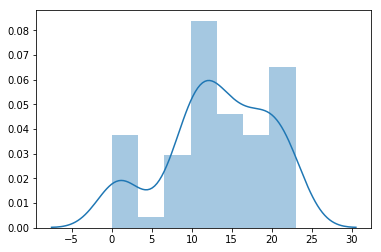

In [403]:
sb.distplot(x)

In [421]:
type(_raw.loc[1, 'dateTime'])

pandas._libs.tslibs.timestamps.Timestamp

In [427]:
list(map(
            classify, data3['IG']
        )
    )

['hyper',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'hyper',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'hyper',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'hyper',
 'hyper',
 'hyper',
 'normo',
 'hyper',
 'normo',
 'normo',
 'hypo',
 'hypo',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'hyper',
 'hyper',
 'hyper',
 'hyper',
 'normo',
 'hyper',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 '

In [453]:
print(data3.index[0] - dt.timedelta(hours=2))
data3.index[0] + dt.timedelta(hours=2)

2019-02-06 22:27:00


Timestamp('2019-02-07 02:27:00')